In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/iliyashafirov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Количество кейсов, в которых выявлены аномалии: 449
Средняя  длительность события для всех кейсов: 11 дней 19 часов 27 минут 56 секунд
Отношение кейсов, в которых выявлены аномалии, к общему числу всех кейсов: 6%


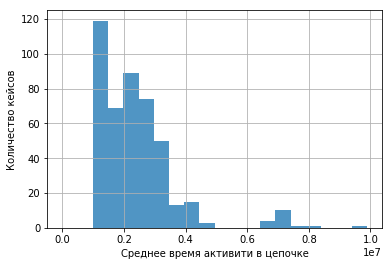

In [24]:
#Выявления цепочек с аномальным временем выполнения

#Подготовка данных к обработке
df = pd.read_csv('Event_log.txt', sep='\t', encoding='cp1251')
df['Event end'] = pd.to_datetime(df['Event end'])
df = df.sort_values(by='Event end')

#Обработка данных: отбор закрытых кейсов
started_cases = set(df.iloc[np.where(df['Activity Category'] == 'Заказ на поставку создан')]['CaseID'])
finished_cases = set(df.iloc[np.where(df['Activity Category'] == 'Платеж (выравнивание)')]['CaseID'])
finished = started_cases & finished_cases
df['finished'] = df['CaseID'].apply(lambda x: x in finished)
df = df[df['finished'] == 1]

#Обработка данных: группировка событий в кейсы
cases = df.groupby(['CaseID'])['Activity'].apply(lambda x: x.sum())
cases = cases.reset_index()
casesun = cases.drop_duplicates(subset=['Activity'])
finished_cases
casesun['Newcount']=casesun['Activity'].map(cases['Activity'].value_counts())
arrcase = df.groupby(['CaseID'])['Activity'].apply(list)
times = df.groupby(['CaseID'])['Event end'].apply(list)

#Анализ данных: вычисление длительности каждого события
def event_dur(arr):
    return np.array(arr[1:]) -  np.array(arr[:-1])
durs = times.apply(lambda x: event_dur(x))
for i in durs.index:
    for j in range(len(durs[i])):
        durs[i][j] = durs[i][j].total_seconds()
case_durs = durs.reset_index()

#Анализ данных: вычисление средней длительности события для каждого кейса
case_durs['average'] = case_durs['Event end'].apply(lambda x: np.mean(x))

#Анализ данных: вычисление средней длительности события для всех кейсов
aver = np.mean(case_durs['average'])
standard = np.std(case_durs['average'])

#Идентификация аномальный кейсов
case_durs['anomaly'] = case_durs['average']  > (aver + standard)



#Вывод результата
def ConvertSectoDay(n): 
  
    day = n // (24 * 3600) 
  
    n = n % (24 * 3600) 
    hour = n // 3600
  
    n %= 3600
    minutes = n // 60
  
    n %= 60
    seconds = n 
      
    return int(day), int(hour), int(minutes), int(seconds)
plt.hist(case_durs['average'][case_durs['anomaly'] == True], bins=20, alpha=0.78, range=[1, max(case_durs['average'])])
plt.grid()
plt.ylabel('Количество кейсов')
plt.xlabel('Среднее время активити в цепочке')
print('Количество кейсов, в которых выявлены аномалии: ' + str(sum(case_durs['average']  > (aver + standard))))
res = ConvertSectoDay(aver + standard)
print('Средняя  длительность события для всех кейсов: ' + str(res[0]) + ' дней ' + str(res[1]) + ' часов ' + str(res[2]) + ' минут ' + str(res[3]) + ' секунд')
print('Отношение кейсов, в которых выявлены аномалии, к общему числу всех кейсов: ' + str(int(100 * round(sum(case_durs['average']  > (aver + standard))/len(cases), 2))) + '%')
